# Machine Learning Project: Employee Turnover Analytics
Chandni Kazi 
03/30/24

In [73]:
import numpy as np 
import pandas as pd
import openpyxl
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cluster as KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [18]:
#Read in the dataset
df = pd.read_excel("1688640705_hr_comma_sep.xlsx")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [48]:
#Rename "sales" to "Department"
df.rename(columns={'sales':'Department',
                   'average_montly_hours':'average_monthly_hours'},inplace=True)
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

Perform data quality checks

In [24]:
#Shape of data frame
print(f'the data frame has {df.shape[1]} features and {df.shape[0]} rows')

the data frame has 10 features and 14999 rows


In [28]:
#variable information 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


### 1. Perform data quality check by checking for missing values if any. 

In [19]:
#any missing values
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [30]:
#summary
df.describe()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [33]:
df.value_counts('sales')

sales
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64

In [37]:
#print all value counts for object variables
def colvals(dataframe):
    """
    loop through the columns fo a dataframe and output the value counts for each column.
    Args: the input dataframe
    Returns: A dictionary where keys are column names and values are the value counts
    """
    value_counts_dict = {}
    for col in dataframe.columns:
        if dataframe[col].dtype =='object':
            value_counts_dict[col]=dataframe[col].value_counts()

    return value_counts_dict

value_results = colvals(df)

for col, value_counts in value_results.items(): 
    print(f"Value counts for column '{col}':\n{value_counts}\n ")

Value counts for column 'Department':
Department
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64
 
Value counts for column 'salary':
salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64
 


### 2.1 Draw a heatmap of the correlation matrix between all numerical features/columns in the data

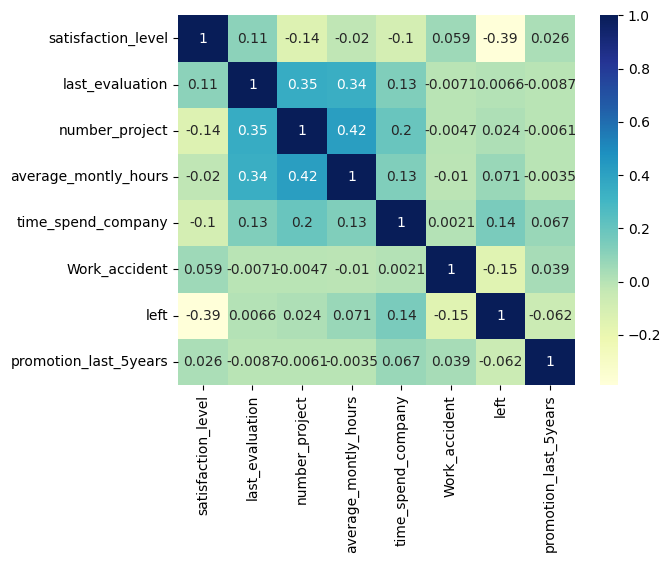

In [42]:
#print(df.corr(numeric_only=True))
heatmapplot = sns.heatmap(df.corr(numeric_only=True),cmap="YlGnBu",annot=True)

### 2.2 Draw the distribution plot of 
- Employee satisfaction (satisfaction_level)
- Employee evaluation (last_evaluation)
- Employee average monthly hours (average_monthly_hours)


[Text(0.5, 1.0, 'Employee Average Monthly Hours')]

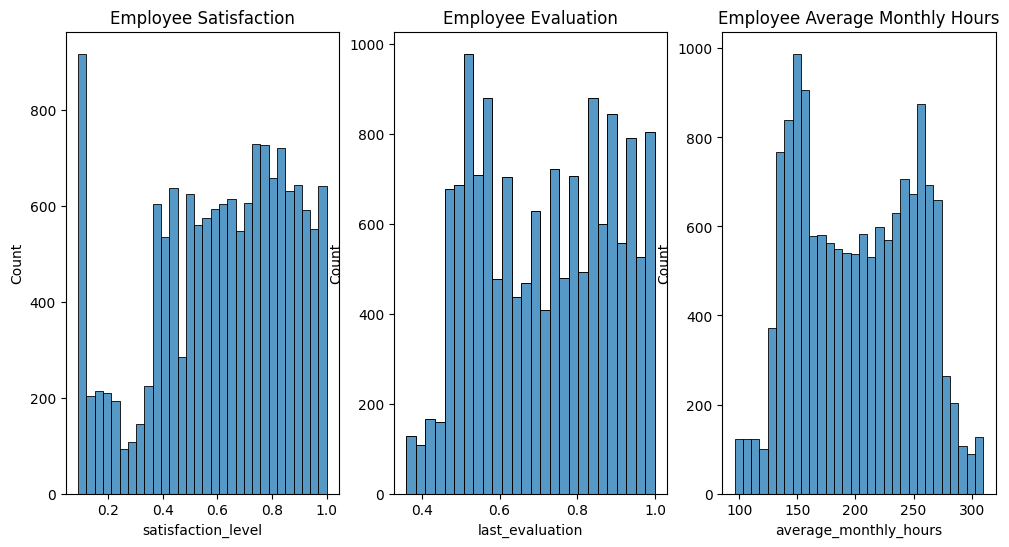

In [57]:
fig,axs = plt.subplots(ncols=3,figsize=(12,6))
sns.histplot(df,x='satisfaction_level',ax=axs[0]).set(title='Employee Satisfaction')
sns.histplot(df,x='last_evaluation',ax=axs[1]).set(title='Employee Evaluation')
sns.histplot(df,x='average_monthly_hours',ax=axs[2]).set(title="Employee Average Monthly Hours")


### 2.3 Draw the bar plot of Employee Project Count of both employees who left and who stayed in the organization (use column number_project and hue column left) and give your inferences from the plot

The bar graph below shows that the average number of projects is slightly higher among employees that left the company than employees that stayed. This visual difference is likely not statistically significant. 

<Axes: ylabel='number_project'>

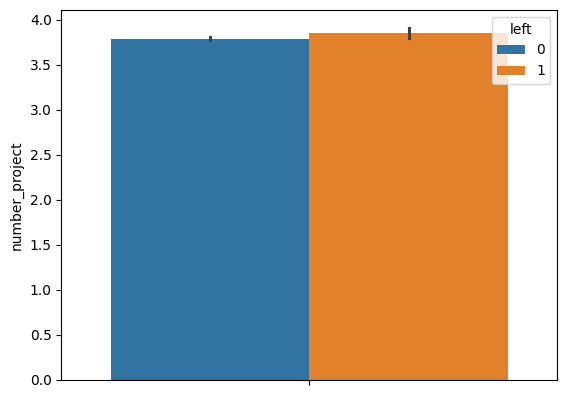

In [61]:
sns.barplot(df,y='number_project',hue='left')

### 3. Perform clustering of employees who left based on their satisfaction and evalution. 
3.1 Choose columns satisfaction_level, last_evaluation and left.
3.2 Do KMeans clustering of employees who left the company into 3 clusters. 
3.3 Based on the satisfaction and evaluation factors, give your thoughts on the employee clusters

In [68]:
#only employees that left the company: 3,571 employees left the company
df_left = df[df['left']==1]
df_left.shape

(3571, 10)

In [78]:
#Create scaled datarfame where variables have mean=0 and std=1
df_left_scaled = StandardScaler().fit_transform(df)

ValueError: could not convert string to float: 'sales'